# CSE 5524 Computer Vision
## Homework Assignment #7
### Points: 25

## Steps to follow before starting on any homework

As a first step before starting on this homework, please save a copy of the provided HW7.ipynb by clicking on File -> Save Notebook As and then using the following file naming convention: lastname_OSUdotNumber_HW7.ipynb (for example: davis_1719_HW7.ipynb) for saving your Notebook file, which you will be working on and submitting for each homework.

Add your name and email by double clicking this cell and editing it.
### Name: Ethan Hessick (.4)
### OSU Email: hessick.4@osu.edu

After editing the cell you can run it by pressing the Shift key + Return key.


## Required Python Packages for Homework 7
1. Numpy (Installation documentation: [https://numpy.org/install/](https://numpy.org/install/))
2. MatPlotLib (Installation documentation: [https://matplotlib.org/stable/index.html#](https://matplotlib.org/stable/index.html#))
3. scikit-image (Installation documentation: [https://scikit-image.org/docs/stable/install.html](https://scikit-image.org/docs/stable/install.html))
4. SciPy (Installation documentation: [https://scikit-image.org/docs/stable/install.html](https://scikit-image.org/docs/stable/install.html))
5. math (Preinstalled Python package)
6. OpenCV (Installation documentation: [https://github.com/opencv/opencv-python](https://github.com/opencv/opencv-python))
7. glob (Preinstalled Python package)


Note: Remember to restart your Notebook kernel by clicking on Kernel -> Restart Kernel... after installing any new packages in order to use the newly installed packages.

In [1]:
# Ensure you have already installed the required packages 
# and then run this cell (Shift+Return)
import matplotlib.pyplot as plt
import numpy as np
import skimage
from skimage.segmentation import slic
from skimage.util import img_as_float
from skimage.segmentation import mark_boundaries
from skimage.color import label2rgb
import cv2 # python -m pip install opencv-contrib-python
import glob
from scipy import ndimage

# Part 1) Template Matching [9 pts]

## i)	Where's Waldo?. Can you find him? Search for the “template” template.png in the “search image” search.png using the following approaches: Sum-of-absolute differences (SAD), Sum-of-squared differences (SSD), and color-based Normalized cross-correlation (NCC). For NCC, make sure the standard deviation is “unbiased” with N-1. (Note: the template did NOT come from the search image.) Assume the origin is in the center of the template image for each approach (Note: there should be a border around the search image where the metrics cannot be computed). Sort the resulting scores from best matches to worst matches. Plot all of the sorted scores (1-D plot) and display all the patches corresponding to the first 50 closest matches in a grid (Hint: Use plt.subplots()). Report the center (x,y) coordinates for the best matching patch (k=1) from each of the three approaches. Compare and discuss the results.

In [2]:
# Read the template and the search image
templateImg = skimage.io.imread('template.png').astype('double')
searchImg = skimage.io.imread('search.png').astype('double')

#print(searchImg.shape)
#print(templateImg.shape)


In [3]:
# 1. SAD

# Write function to do this
# Inputs:
# template = template image (in skimage format)
# image = search image to look through (in skimage format)
# calcType = SAD, SSD, or NCC
# Outputs:
# sortedScores = 3x(number of possible origins) array that holds the array coords and score. The values are sorted by the scores
def templateSearch(template, image, calcType):

    # define search range
    templateRows = template.shape[0]
    templateCols = template.shape[1]
    searchRows = image.shape[0]
    searchCols = image.shape[1]

    searchRowStart = int(np.floor(templateRows / 2))
    searchRowStop = int(searchRows - searchRowStart)
    searchColStart = int(np.floor(templateCols / 2))
    searchColStop = int(searchCols - searchColStart)

    # make array to hold sorted scores
    scores = np.zeros([(searchRowStart-searchRowStop)*(searchColStart-searchColStop), 3])

    # cycle through every possible origin point
    index = 0
    for row in range(searchRowStart, searchRowStop):
        for col in range(searchColStart, searchColStop):
            
            # define patch coordinates
            rowStart = int(row - np.floor(templateRows / 2))
            rowEnd = int(row + np.floor(templateRows / 2)) + 1
            colStart = int(col - np.floor(templateCols / 2))
            colEnd = int(col + np.floor(templateCols / 2)) + 1

            # print(rowStart, rowEnd, colStart, colEnd) # debugging
            patch = image[rowStart:rowEnd, colStart:colEnd, :] # get patch
            # print(patch.shape)

            if calcType == 'SAD': # for SAD do difference of each pixel, take absolute value, then sum
                diff = template - patch 
                diff /= np.size(diff) # average for colors and number of pixels
                diff = np.abs(diff)
                SAD_score = np.sum(diff)
                scores[index] = [SAD_score, row, col]

            elif calcType == 'SSD': # for SSD do difference of each pixel, square it, then sum
                diff = template - patch 
                diff /= np.size(diff) # average for colors and number of pixels
                diff = diff**2
                SSD_score = np.sum(diff)
                scores[index] = [SSD_score, row, col]

            elif calcType == 'NCC': # for NCC normalize the patch and template (by color) then elementwise-multiply the values and sum values for each pixel
                scoreSum = 0
                for color in range(0, template.shape[2]): # do independently for each color
                    # calculate the Mean pixel values for the patch and template
                    tAvg = np.mean(template[:,:,color])
                    pAvg = np.mean(patch[:,:,color])

                    # calculate the Standard Deviation of values for the patch and template
                    tStd = np.std(template[:,:,color], ddof=1) # ddof = 1 to make unbiased
                    pStd = np.std(patch[:,:,color], ddof=1)

                    # mean subtract each and divide by standard deviation
                    normalizedTemplate = (template[:,:,color] - tAvg) / tStd
                    normalizedPatch = (patch[:,:,color] - pAvg) / pStd

                    # element wise multiplication of the normalized template and patch
                    nccPixelValues = np.multiply(normalizedTemplate, normalizedPatch)

                    # add the sum to the the score
                    scoreSum += np.sum(nccPixelValues) / ((template.shape[0]*template.shape[1]-1) *template.shape[2])# divide sum by number of pixels - 1 and colors (divide by shape[2])

                scores[index] = [scoreSum, row, col]
            
            else: 
                print("ERROR: Incorrect input for 'calcType'.")
                return
            index += 1
    
    # sort scores
    sortedIndices = np.argsort(scores[:,0])

    if calcType == "NCC":
        sortedIndices = np.flip(sortedIndices) # want to maximize NCC (for others want to minimize) - so need flipped sorting
        
    sortedScores = scores[sortedIndices]
    return sortedScores

sad_scores = templateSearch(templateImg, searchImg, "SAD")




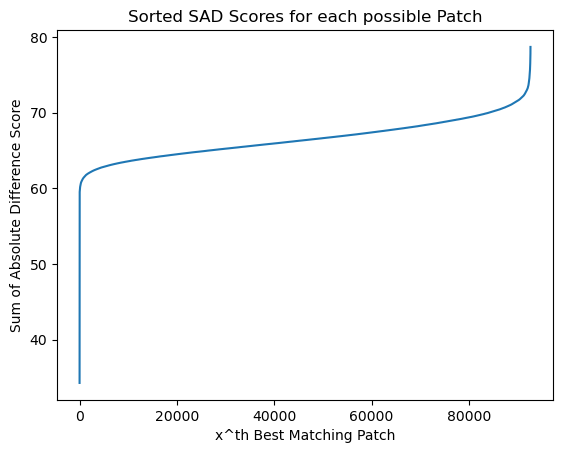

In [4]:
# Plot all of the sorted SAD scores (1-D plot) 

plt.plot(sad_scores[:,0])
plt.ylabel("Sum of Absolute Difference Score")
plt.xlabel("x^th Best Matching Patch")
plt.title("Sorted SAD Scores for each possible Patch")
plt.show()


The Origin of the best matching patch for SAD is at (X,Y) = (309,88).


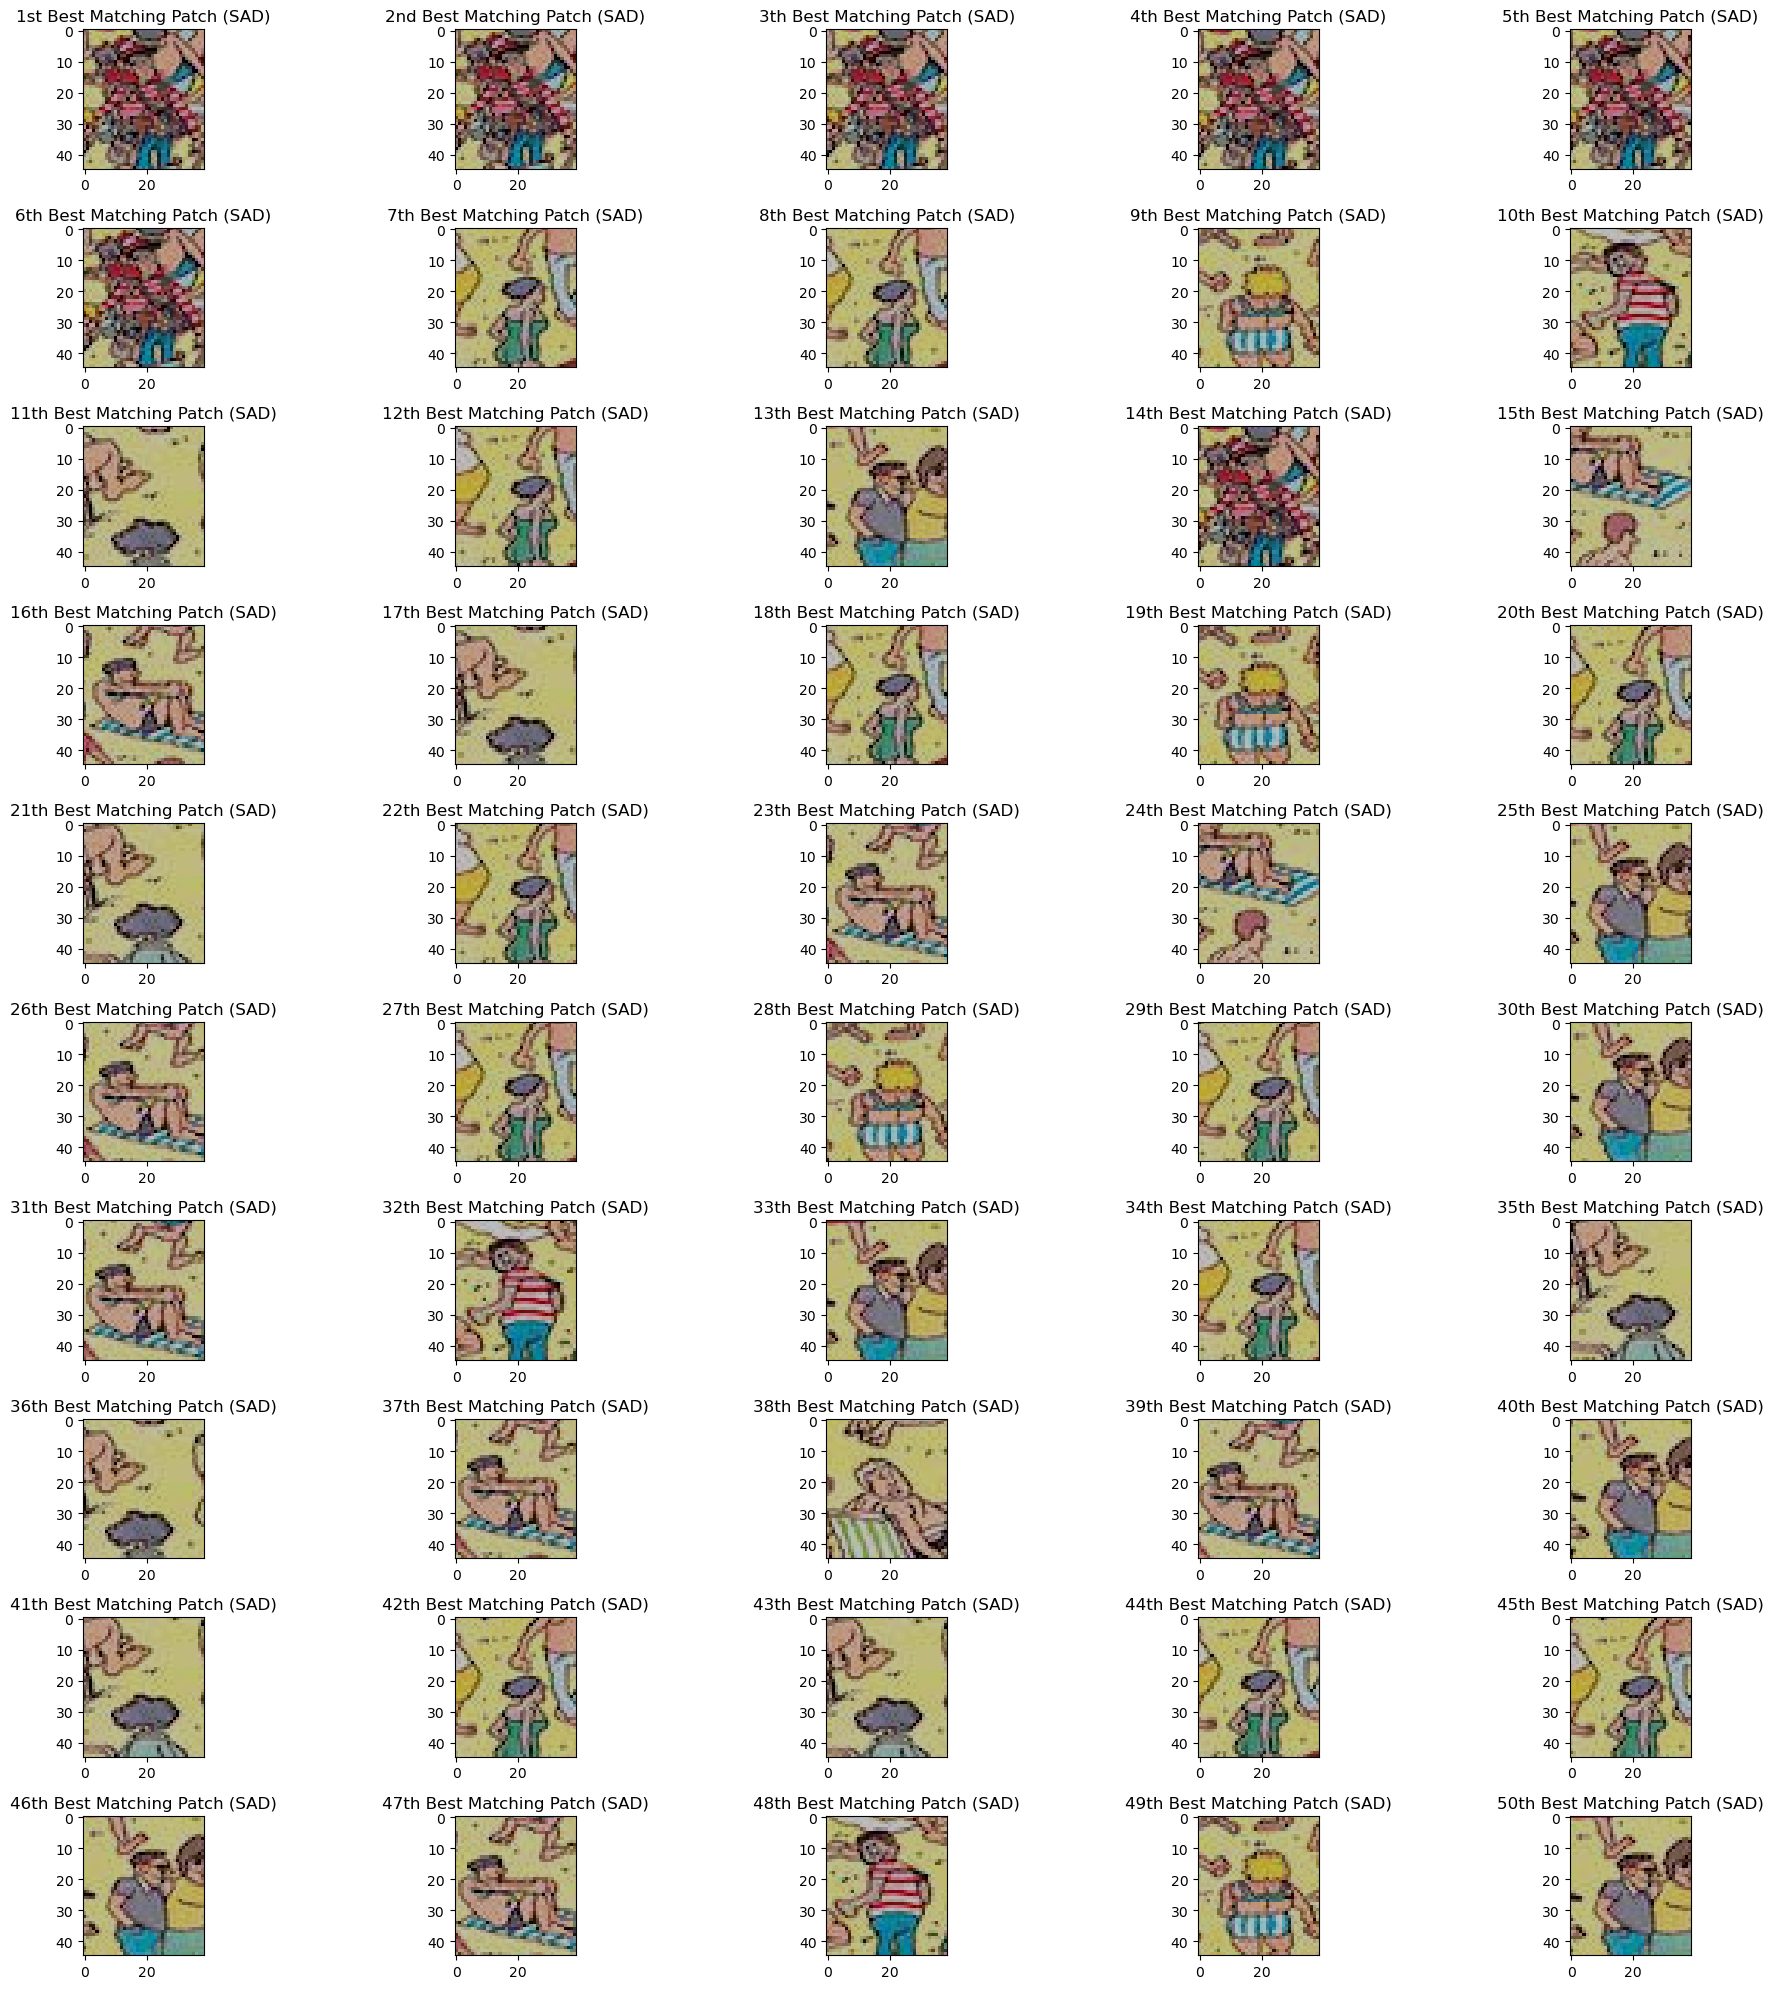

In [5]:
# Display the patches corresponding to 
# the first 50 closest matches

# print X,Y of best plot
print(f"The Origin of the best matching patch for SAD is at (X,Y) = ({sad_scores[0,2]:0.0f},{sad_scores[0,1]:0.0f}).")

# make subplot
fig, ax = plt.subplots(10, 5, figsize=(20,20))

templateRows = templateImg.shape[0]
templateCols = templateImg.shape[1]

    # cycle through top 50 matches
for i in range(0, 50):
    axRow = int(np.floor(i / 5))
    axCol = int(i % 5)

    # find origin
    centerRow = sad_scores[i,1]
    centerCol = sad_scores[i,2]

    # find patch outline
    rowStart = int(centerRow - np.floor(templateRows / 2))
    rowEnd = int(centerRow + np.floor(templateRows / 2)) + 1
    colStart = int(centerCol - np.floor(templateCols / 2))
    colEnd = int(centerCol + np.floor(templateCols / 2)) + 1

    patch = searchImg[rowStart:rowEnd, colStart:colEnd, :].astype('int') # get patch as integers for display

    # display patch on the subplot
    ax[axRow, axCol].imshow(patch)
    if i == 0:
        titleString = f"{i+1}st Best Matching Patch (SAD)"
    elif i == 1:
        titleString = f"{i+1}nd Best Matching Patch (SAD)"
    else:
        titleString = f"{i+1}th Best Matching Patch (SAD)"
    ax[axRow, axCol].set_title(titleString)

plt.tight_layout() # spacing
plt.show()


In [6]:
# 2. SSD - See SSD code section in function in second block in this section
ssd_scores = templateSearch(templateImg, searchImg, "SSD")


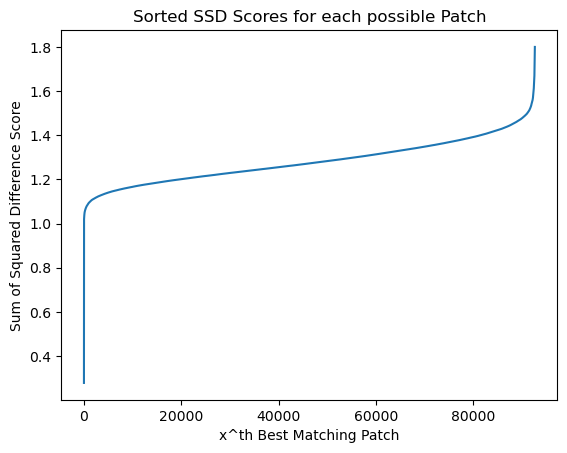

In [7]:
# Plot all of the sorted SSD scores (1-D plot) 

plt.plot(ssd_scores[:,0])
plt.ylabel("Sum of Squared Difference Score")
plt.xlabel("x^th Best Matching Patch")
plt.title("Sorted SSD Scores for each possible Patch")
plt.show()


The Origin of the best matching patch for SSD is at (X,Y) = (309,88).


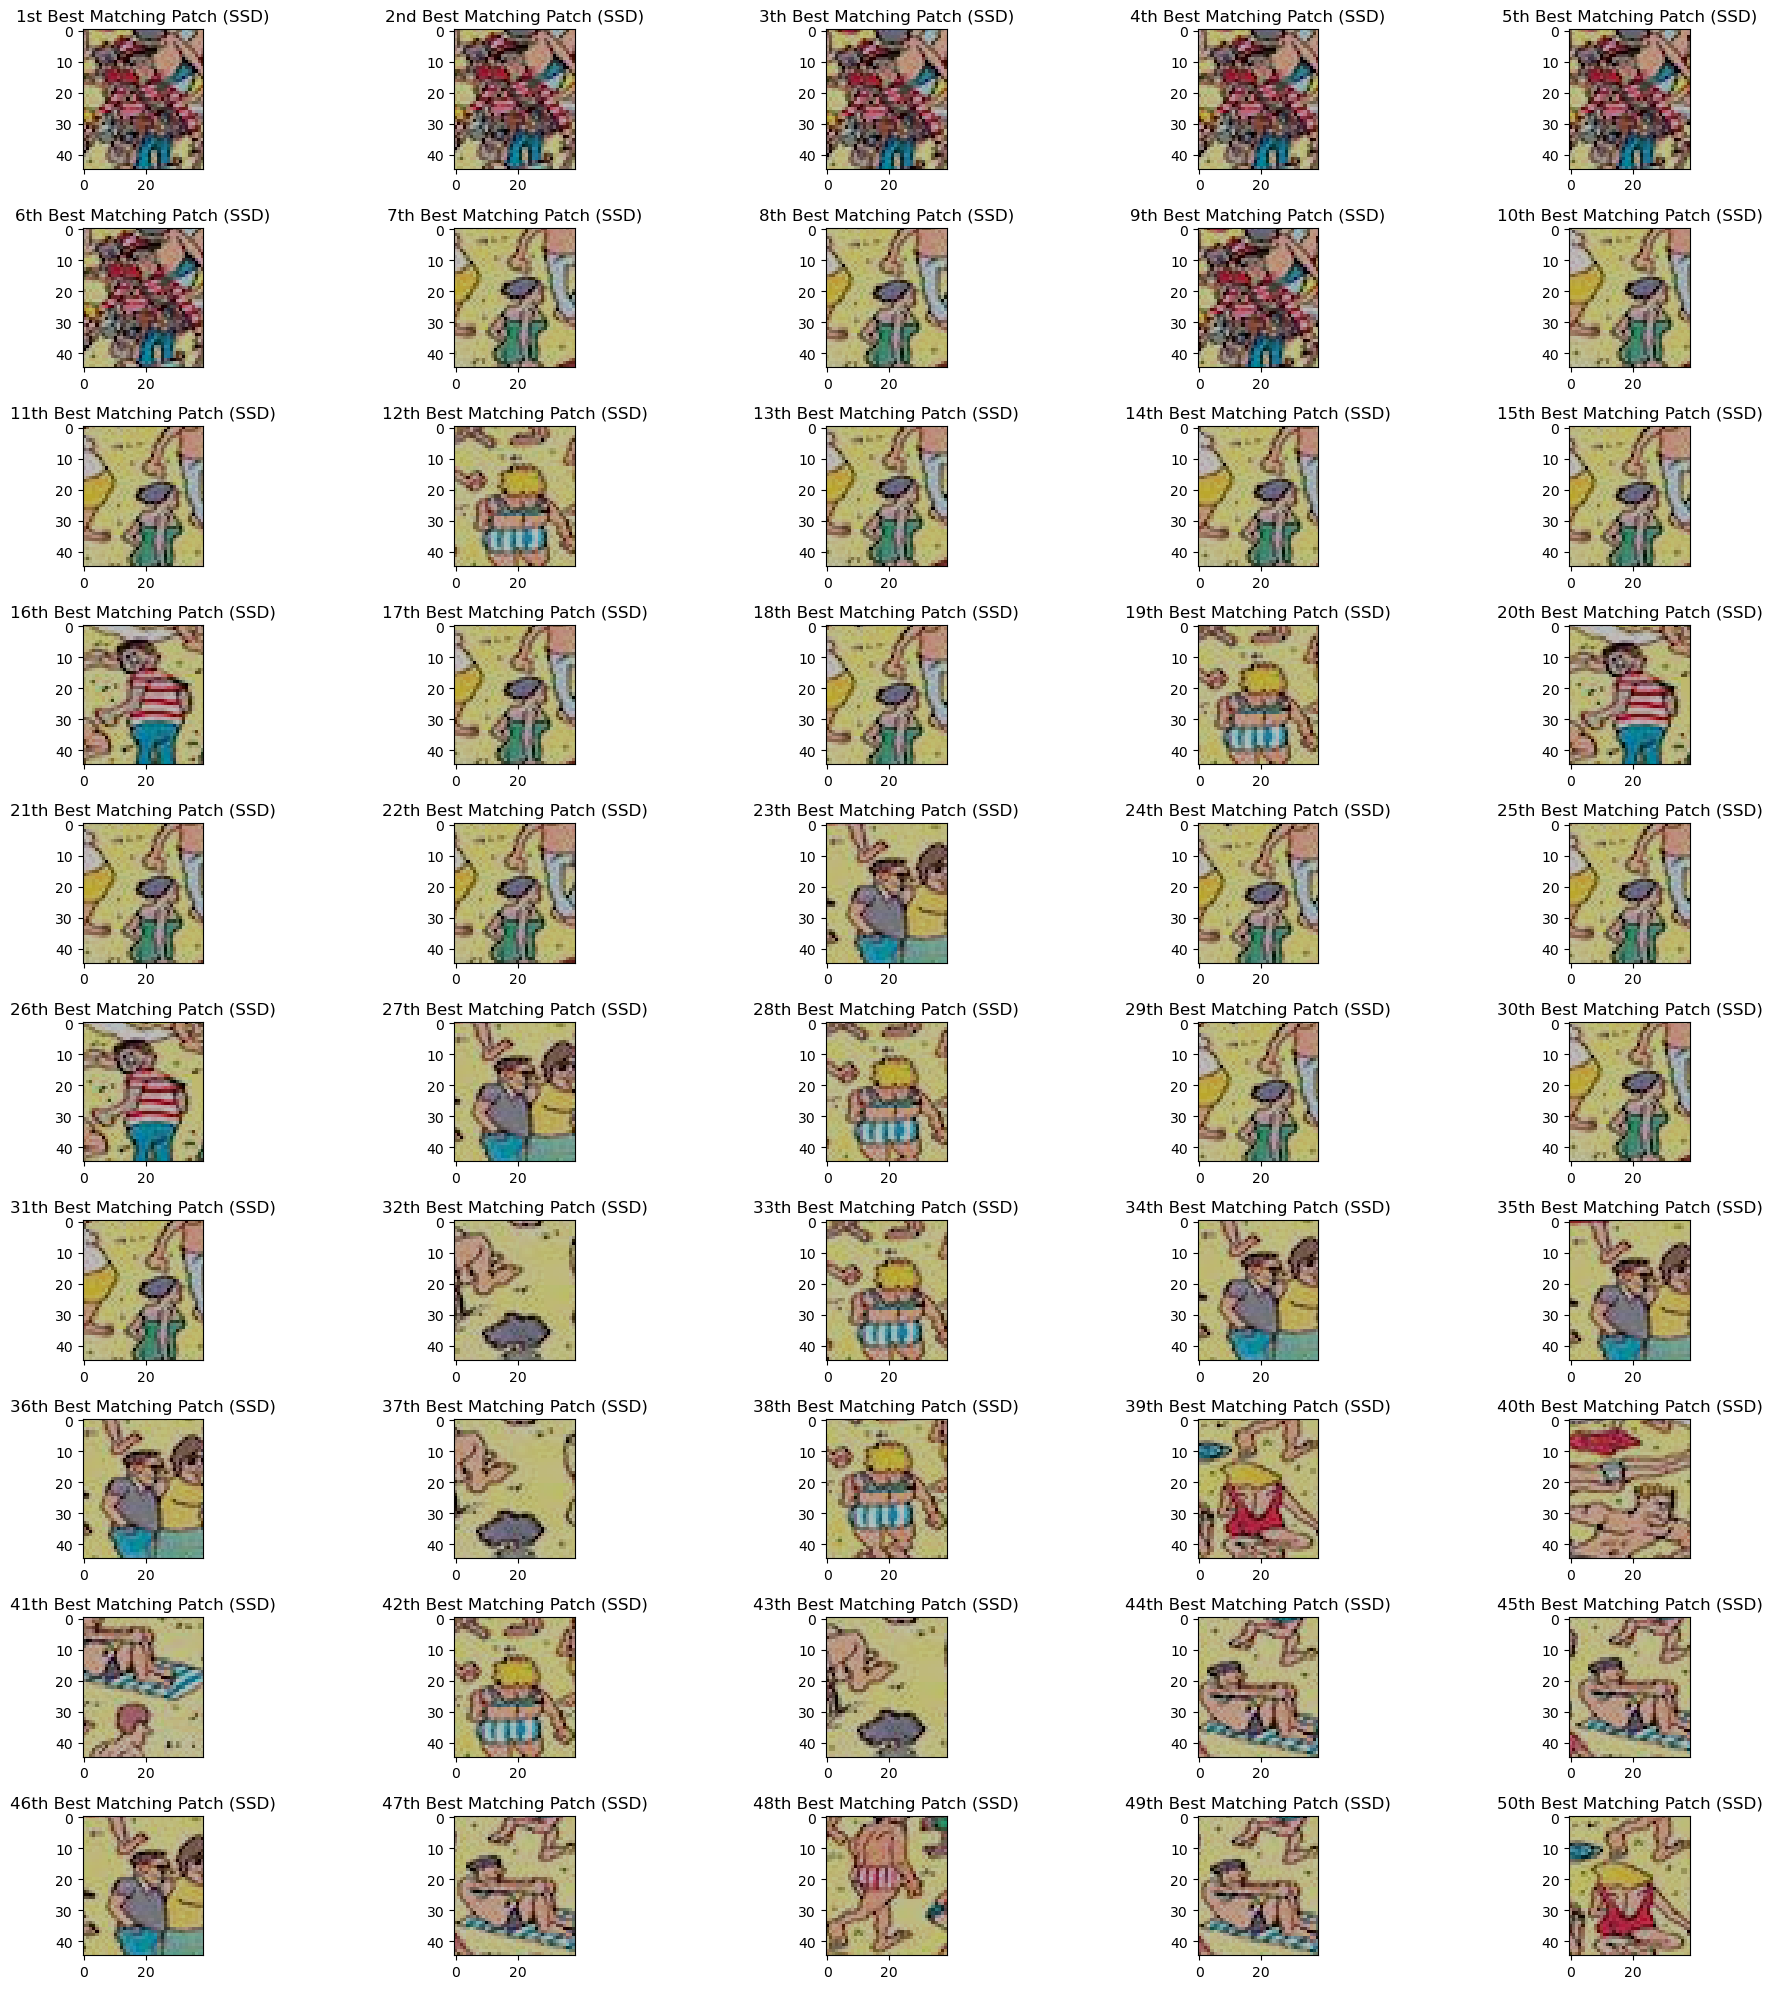

In [8]:
# Display the patches corresponding to the 
# first 50 closest matches

# print X,Y of best plot
print(f"The Origin of the best matching patch for SSD is at (X,Y) = ({ssd_scores[0,2]:0.0f},{ssd_scores[0,1]:0.0f}).")

# make subplot
fig, ax = plt.subplots(10, 5, figsize=(20,20))

templateRows = templateImg.shape[0]
templateCols = templateImg.shape[1]

    # cycle through top 50 matches
for i in range(0, 50):
    axRow = int(np.floor(i / 5))
    axCol = int(i % 5)

    # find origin
    centerRow = ssd_scores[i,1]
    centerCol = ssd_scores[i,2]

    # find patch outline
    rowStart = int(centerRow - np.floor(templateRows / 2))
    rowEnd = int(centerRow + np.floor(templateRows / 2)) + 1
    colStart = int(centerCol - np.floor(templateCols / 2))
    colEnd = int(centerCol + np.floor(templateCols / 2)) + 1

    patch = searchImg[rowStart:rowEnd, colStart:colEnd, :].astype('int') # get patch as integers for display

    # display patch on the subplot
    ax[axRow, axCol].imshow(patch)
    if i == 0:
        titleString = f"{i+1}st Best Matching Patch (SSD)"
    elif i == 1:
        titleString = f"{i+1}nd Best Matching Patch (SSD)"
    else:
        titleString = f"{i+1}th Best Matching Patch (SSD)"
    ax[axRow, axCol].set_title(titleString)

plt.tight_layout() # spacing
plt.show()


In [9]:
# 3. NCC - See NCC Section in the templateSearch function in the second block code for this question
ncc_scores = templateSearch(templateImg, searchImg, "NCC")


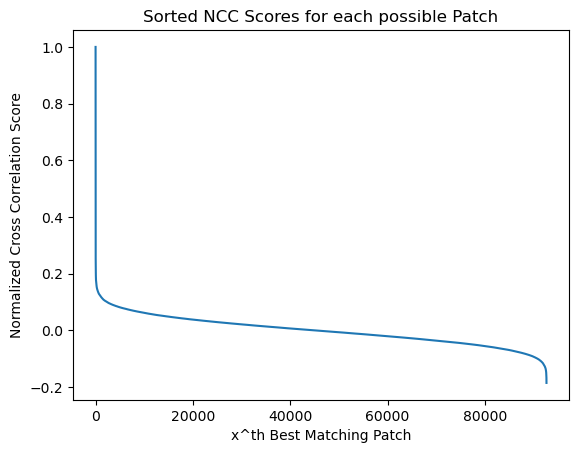

In [26]:
# Plot all of the sorted NCC scores (1-D plot) 
plt.plot(ncc_scores[:,0])
plt.ylabel("Normalized Cross Correlation Score")
plt.xlabel("x^th Best Matching Patch")
plt.title("Sorted NCC Scores for each possible Patch")
plt.show()


The Origin of the best matching patch for NCC is at (X,Y) = (309,88).


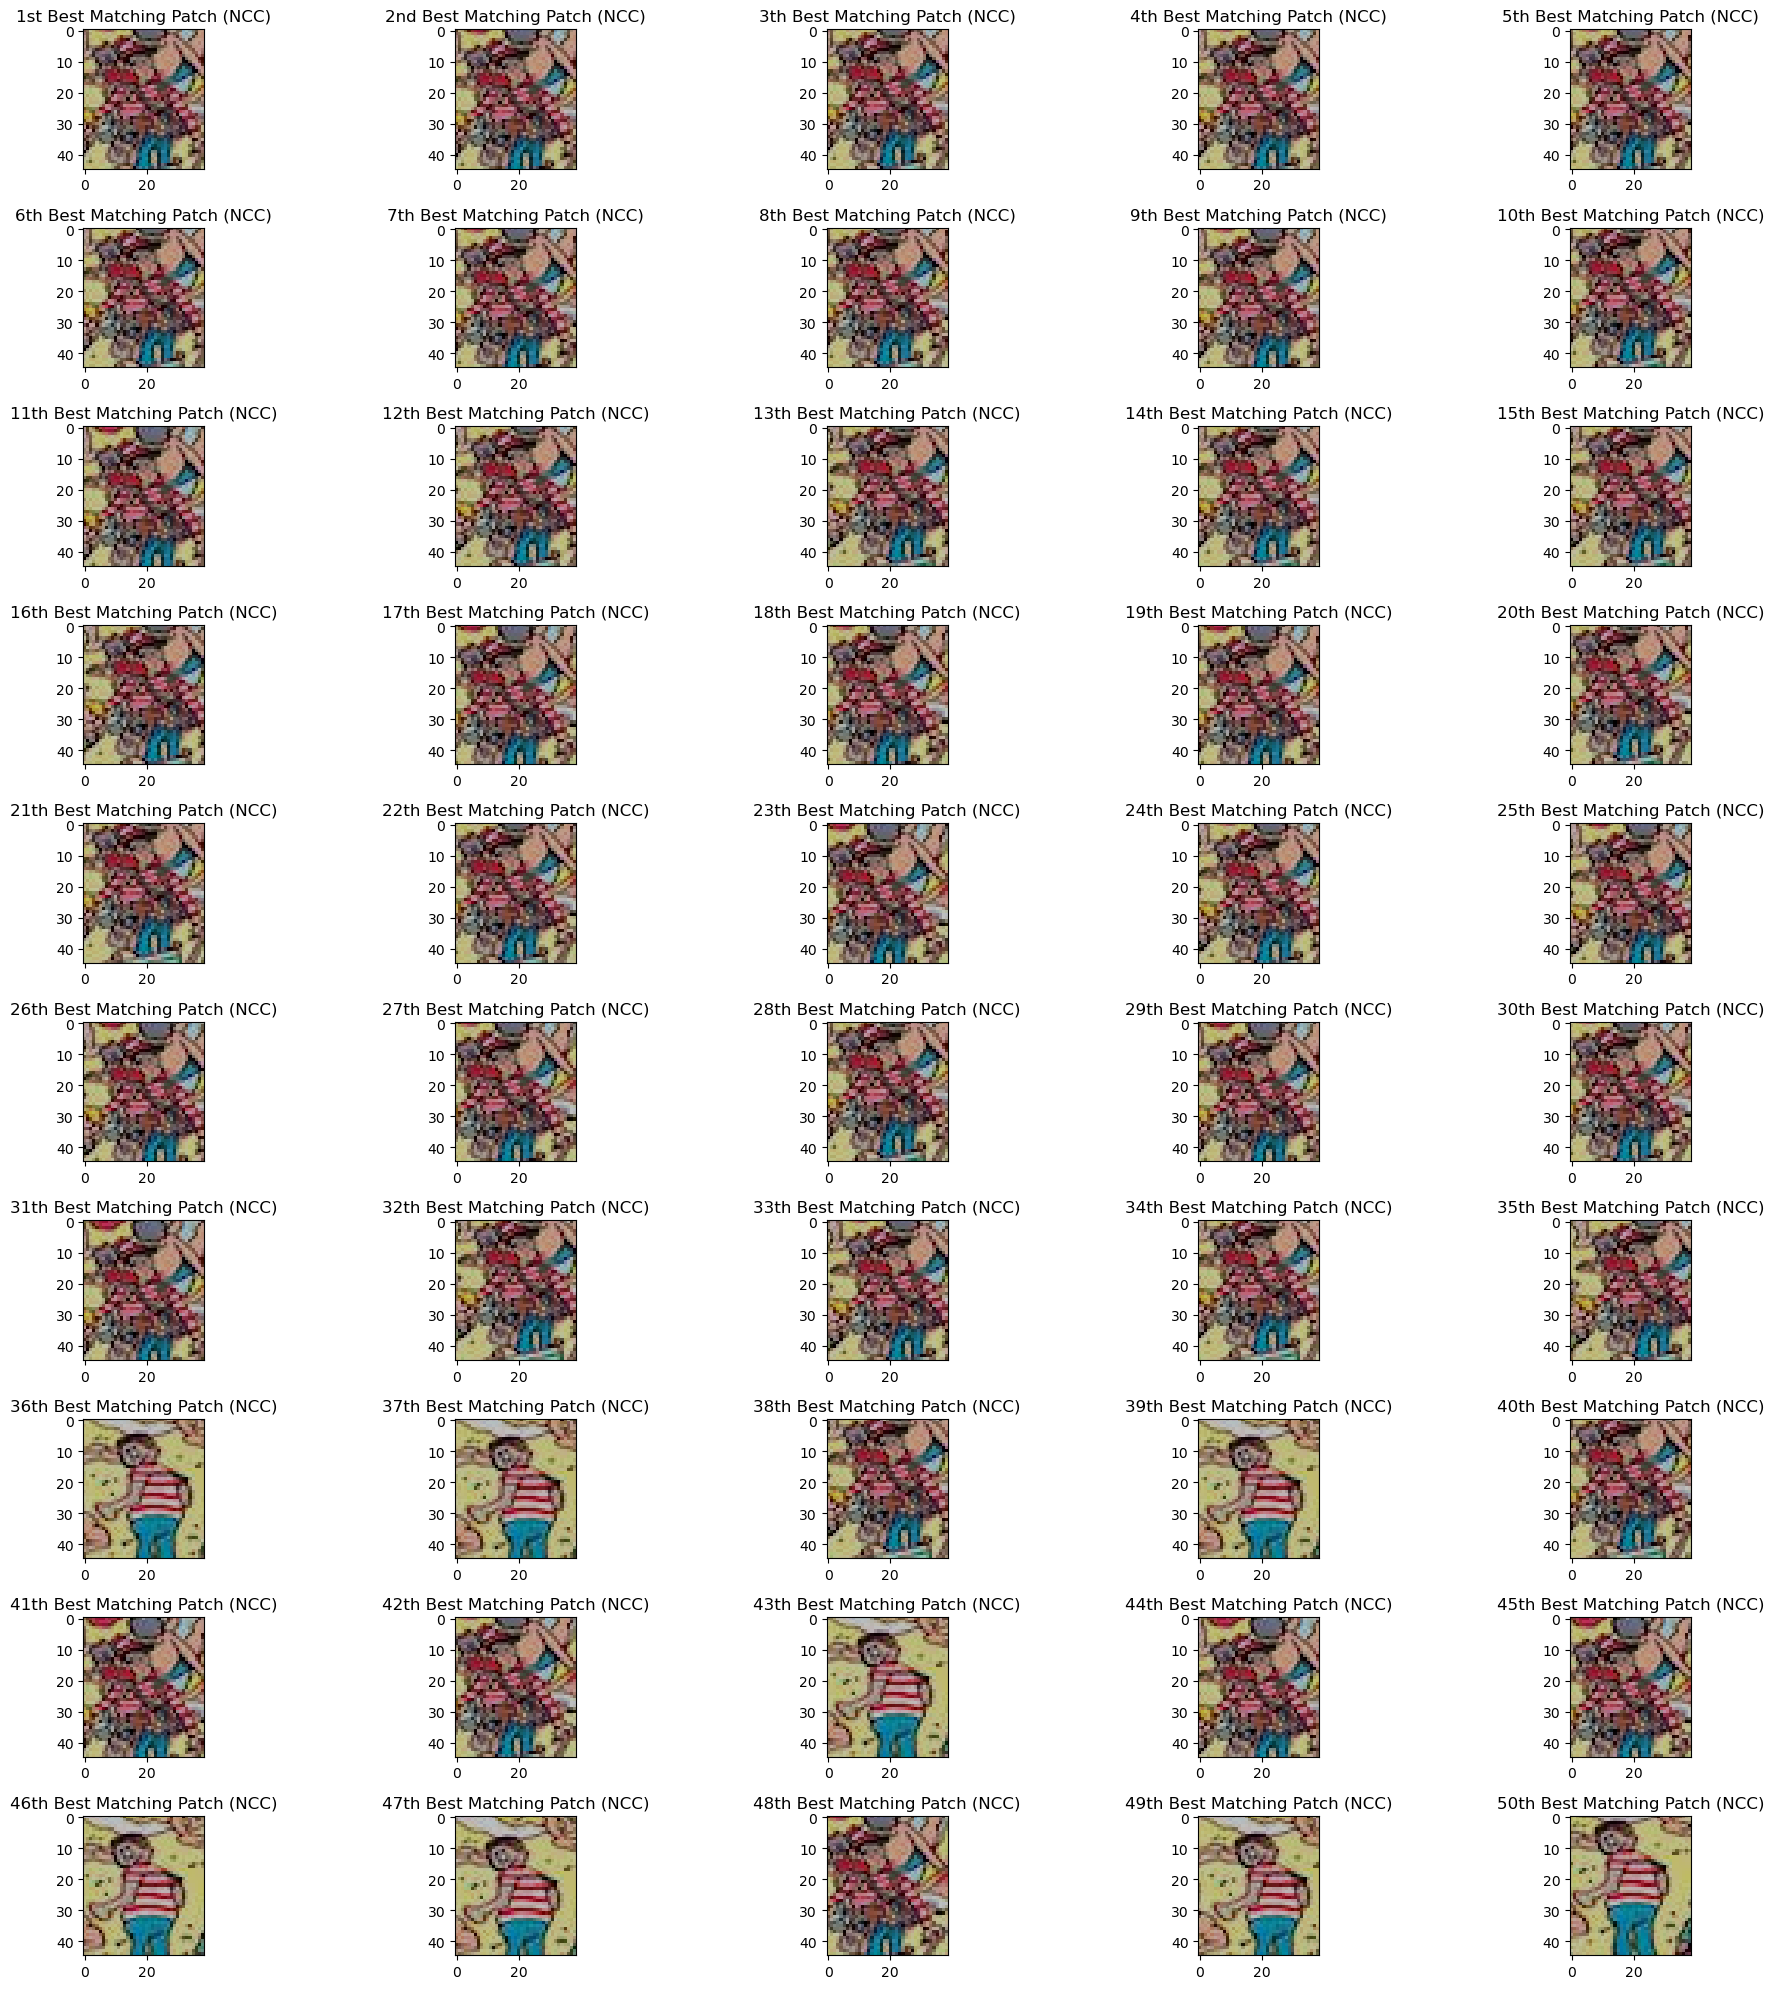

In [11]:
# Display the patches corresponding to the 
# first 50 closest matches

# print X,Y of best plot
print(f"The Origin of the best matching patch for NCC is at (X,Y) = ({ncc_scores[0,2]:0.0f},{ncc_scores[0,1]:0.0f}).")

# make subplot
fig, ax = plt.subplots(10, 5, figsize=(20,20))

templateRows = templateImg.shape[0]
templateCols = templateImg.shape[1]

    # cycle through top 50 matches
for i in range(0, 50):
    axRow = int(np.floor(i / 5))
    axCol = int(i % 5)

    # find origin
    centerRow = ncc_scores[i,1]
    centerCol = ncc_scores[i,2]

    # find patch outline
    rowStart = int(centerRow - np.floor(templateRows / 2))
    rowEnd = int(centerRow + np.floor(templateRows / 2)) + 1
    colStart = int(centerCol - np.floor(templateCols / 2))
    colEnd = int(centerCol + np.floor(templateCols / 2)) + 1

    patch = searchImg[rowStart:rowEnd, colStart:colEnd, :].astype('int') # get patch as integers for display

    # display patch on the subplot
    ax[axRow, axCol].imshow(patch)
    if i == 0:
        titleString = f"{i+1}st Best Matching Patch (NCC)"
    elif i == 1:
        titleString = f"{i+1}nd Best Matching Patch (NCC)"
    else:
        titleString = f"{i+1}th Best Matching Patch (NCC)"
    ax[axRow, axCol].set_title(titleString)

plt.tight_layout() # spacing
plt.show()


### Discussion
All three methods found the best possible match to be the patch at origin (309,88). \
The NCC method performed the best in finding Waldo even at lower matches. Most of the 50 best matching patches contain Waldo and the ones that do not instead have a man who is also wearing jeans and a red-white striped shirt. For the SAD and SSD results, only the top 6 matches contain Waldo. Interestingly, the rest do contain people, but just not Waldo. \
Another important difference between the methods can be seen in the score differences. The NCC had a value of 1 for the best match - which means its a perfect match (essentially its the same image under different lighting). The SAD and SSD scores did not have 0 for the perfect match - since the template was not exactly from the search image. \
The one downside to the NCC method was that it took my computer about 7X longer to do the NCC method than the SAD and SSD methods. This could probably be improved by using more computing power or writing more efficient code. However, for applications where speed is essential and the patch is very predictable, it might be better to use SAD or SSD since they are quicker and less computationally expensive. 

# Part 2)	 Histogram of Oriented Gradients [6 pts]

### i. Load the given 'volcano.png' image, normalize the image to [0,1] range, and convert it to grayscale (single-channel) and display the resulting image.

### ii. Calculate the gradients of the image using normalized Sobel masks. Display the x-gradient, y-gradient, and gradient magnitude images. Report the mean value (rounded to 4 decimal places) of the gradient magnitude image.

### iii. Calculate the gradient orientations (Hint: Use np.arctan2) and then convert the resulting angles from radian to degrees in the range [0, 360). (Note: 360 is not included in the interval, hence map any 360 degree angle values to 0 degrees). 

### iv. Quantize the gradients (counts) into a 60-bin histogram using the gradient orientation angles. Each bin has a width of 6 degrees and does not include the right bin edge value. Example: the first bin [0,6) will include 0 but not 6. Report the counts in the first five bins of the histogram.

### v. Finally normalize the histogram, and display a polar plot (Hint: plt.polar()) showing the normalized histogram counts by building a list of (theta, r) polar coordinates where theta is the left bin edge angle and r is the corresponding normalized histogram counts in that bin. Append the r value from the first bin (left bin edge angle: 0) to the end of the list as the corresponding r value for theta=360 to make the plot continuous. (Note: Make sure you convert the angles from degrees back to radian before plotting as plt.polar() works with angles in radian not degrees). 

### vi. Discuss the insights gained about the image from the orientation of the gradients in the polar plots. 

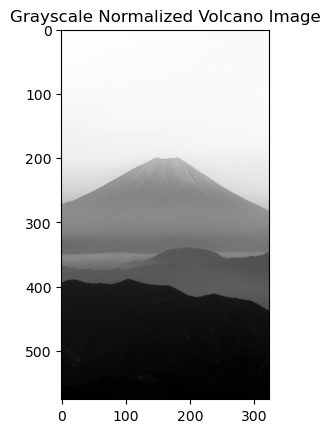

In [12]:
# Load the image, convert to grayscale, and display the image

# Load the image
import skimage.color

rawVolcanoImg = skimage.io.imread('volcano.png').astype('double')

# convert to grayscale
procVolcanoImg = skimage.color.rgb2gray(rawVolcanoImg)

# normalize between 0 and 1
procVolcanoImg = (procVolcanoImg - np.min(procVolcanoImg)) / (np.max(procVolcanoImg) - np.min(procVolcanoImg))

# display image
plt.imshow(procVolcanoImg, cmap='gray')
plt.axis('image')
plt.title("Grayscale Normalized Volcano Image")
plt.show()



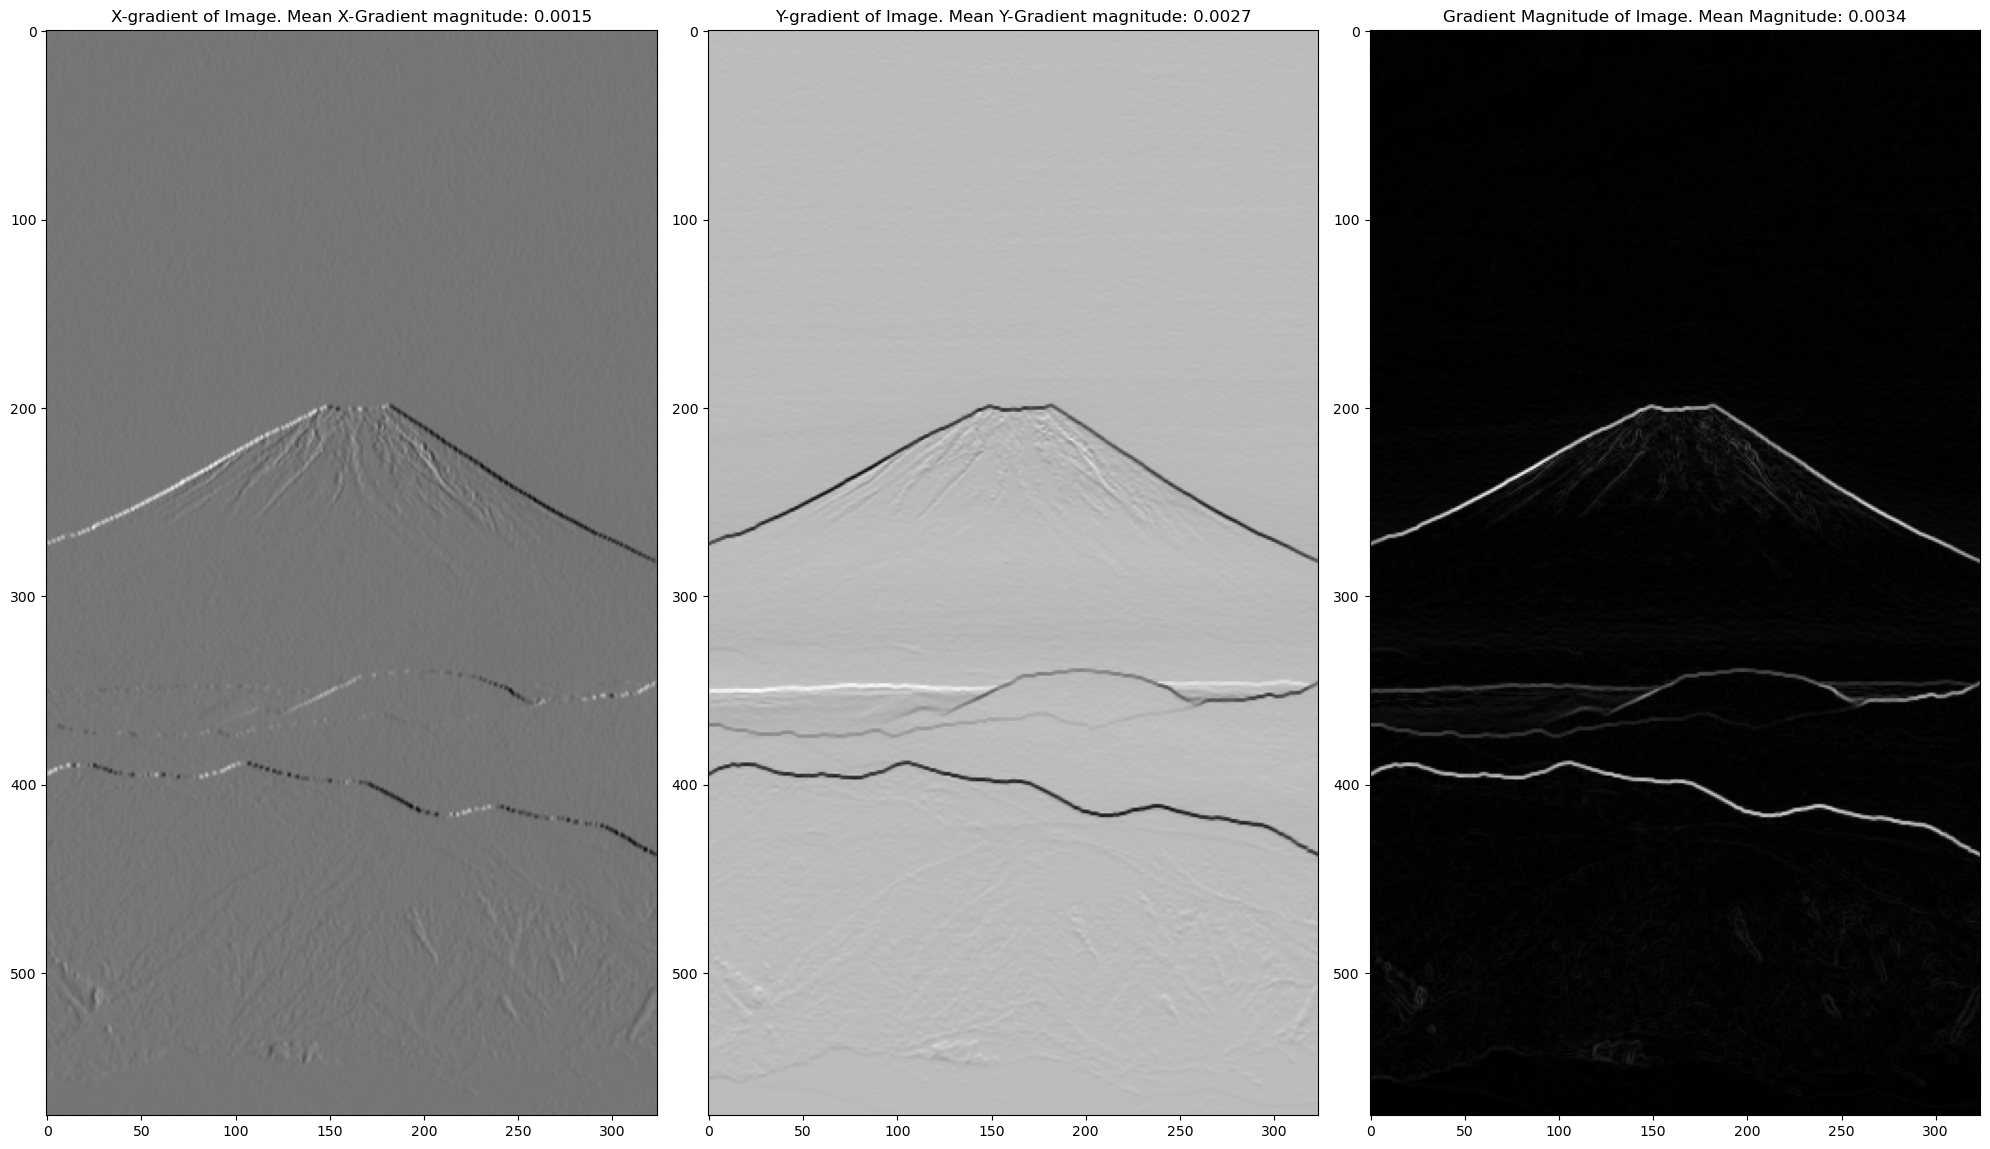

In [13]:
# Caclulate gradients and display 

# create  sobel x mask
sobel_x = np.array([[-1, 0, 1],\
                    [-2, 0, 2],\
                    [-1, 0, 1]]).astype('double')

sobel_x /= np.sum(np.abs(sobel_x))

# create sobel y mask
sobel_y = np.array([[1, 2, 1],\
                    [0, 0, 0],\
                    [-1, -2, -1]]).astype('double')

sobel_y /= np.sum(np.abs(sobel_y))

# convolve to get gradient x, y images
Fx_img = ndimage.convolve(procVolcanoImg, sobel_x)

Fy_img = ndimage.convolve(procVolcanoImg, sobel_y)

# convert to gradient magnitude
gradient_mag_img = np.sqrt(Fx_img**2 + Fy_img**2)

# display all three of the gradients
fig, ax = plt.subplots(1,3, figsize=(20,20))

ax[0].imshow(Fx_img, cmap='gray')
ax[0].set_title(f"X-gradient of Image. Mean X-Gradient magnitude: {np.mean(np.abs(Fx_img)):0.4f}")
ax[0].axis('image')

ax[1].imshow(Fy_img, cmap='gray')
ax[1].set_title(f"Y-gradient of Image. Mean Y-Gradient magnitude: {np.mean(np.abs(Fy_img)):0.4f}")
ax[1].axis('image')

ax[2].imshow(gradient_mag_img, cmap='gray')
ax[2].set_title(f"Gradient Magnitude of Image. Mean Magnitude: {np.mean(gradient_mag_img):0.4f}")
ax[2].axis('image')

# spacing and display
plt.tight_layout()
plt.show()

In [14]:
# Caclulate gradient orientations in degrees ranging 
# in the interval (0, 360]

# create array to hold orientations
img_orientations = np.zeros(procVolcanoImg.shape)

img_orientations = np.arctan2(Fy_img, Fx_img) # y then x for angle 0 starting at + x axis. 

# convert from degrees to radians:
img_orientations *= (180 / np.pi)

# convert (0, -180] to [180, 360)
img_orientations = np.where(img_orientations < 0, 360 + img_orientations, img_orientations)
# convert 360 to  0 
img_orientations = np.where(img_orientations == 360, 0, img_orientations)

print(f"Minimum:{np.min(img_orientations)}, Maximum:{np.max(img_orientations)}") # testing


Minimum:0.0, Maximum:359.99999999999994


In [15]:
# Quantize the gradients into a histogram following
# the instructions above

# make an array that holds the bin number for each pixel
img_bins_60 = np.floor(img_orientations / 6)

# translate that array into array with the count for each bin
hist_bins_60 = np.zeros([60]) # initialize bins

for i in range(0,60):
    hist_bins_60[i] = np.sum(np.where(img_bins_60 == i, 1, 0)) # add count to of each bin label to each array value

# print count for the first five bins
for i in range(0,5):
    print(f"In Bin #{i+1} including values in the range [{i*6},{(i+1)*6}) has a count of {hist_bins_60[i]:.0f} pixels.")


# print(np.sum(hist_bins_60)) # ensuring the right number of pixels is counted
# print(np.size(img_bins_60))


In Bin #1 including values in the range [0,6) has a count of 5846 pixels.
In Bin #2 including values in the range [6,12) has a count of 1474 pixels.
In Bin #3 including values in the range [12,18) has a count of 1326 pixels.
In Bin #4 including values in the range [18,24) has a count of 2269 pixels.
In Bin #5 including values in the range [24,30) has a count of 1474 pixels.


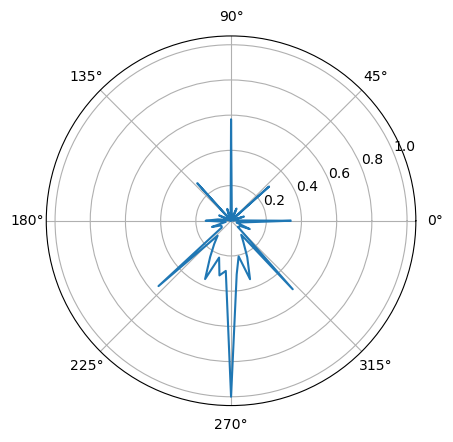

In [16]:
# Plot a polar plot of the normalized histogram counts 
# Append the value of the first bin (angle 0) as the 
# value for the final angle 360

# Normalize the histogram
normalized_hist = (hist_bins_60 - np.min(hist_bins_60)) / (np.max(hist_bins_60) - np.min(hist_bins_60))
# print(np.min(normalized_hist), np.max(normalized_hist)) # testing

# build list of (theta, r) polar coordinates - theta = minimum edge angle, r = normalized count
polar_coords = np.zeros([61,2])
polar_coords[0:60,1] = normalized_hist # r values
polar_coords[0:60,0] = [i*6 for i in range(0,60)] # theta values

# add theta = 360, r = r @ (theta = 0) to end of list
polar_coords[60,:] = [360, normalized_hist[0]]

# convert angles to radians
polar_coords[:, 0] *= (np.pi / 180)

# display polar plot using plt.polar()
plt.polar(polar_coords[:,0], polar_coords[:,1])
plt.show()



### Discussion
The polar plot has its largest spikes in the vertical directions, suggesting the photo has a lot of horizontal edges or generally gets brighter/darker in the vertical directions. Looking at the volcano image, this is true!

The polar plot also has spikes at 225°, 315°, 45°, and 135° that are likely due to the slanted volcano edges. 

One thing that I am worried about is that the larger spike is at 270° conpared to 90°. Most of the horizontal edges in the photo would be at 90°, since the image is getting brighter in the up direction. The larger spike downward suggests that there are a lot of pixels within each similar region where the intensity gets slightly higher in the downward direction (lighter near the base). One way to improve this issue would be to use a weighted histogram (by weighting the gradient magnitudes instead of using a count of each pixel). 

## Part 3)	SLIC [4 pts]

### i. Load and display the provided 'iceland.png' image. 

### ii. Run the SLIC superpixel segmentation algorithm (skimage.segmentation.slic()) on the image and experiment with the following target number of superpixels: [50,100,150,200] and compactness: [0.01, 0.1, 1, 10, 100]. 

### iii. Display the segmentation results by painting each segment with the mean color value of the respective segment (replace the original image pixel RGB values in a segment with the mean RGB pixel values of that particular segment). Note: You can only use NumPy functions to paint the segments. 

### iv. Report the overall mean pixel intensity value (averaged over all three color channels for the entire image) for each of the painted image results. 

### v. Discuss the results. 

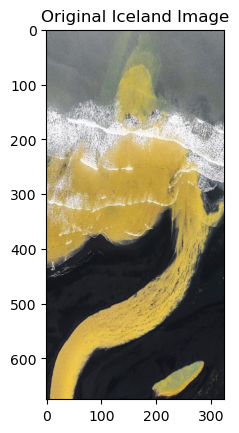

In [17]:
# Read and display the input image for the 
# SLIC superpixel segmentation algorithm

icelandImg = skimage.io.imread("iceland.png") # read

plt.imshow(icelandImg)
plt.axis("image")
plt.title("Original Iceland Image")
plt.show()


In [18]:
# Run the SLIC experiment for different values of the 
# target number of superpixels (num_segments) and compactness (comp)

num_segments = [50,100,150,200]
comp = [0.01, 0.1, 1, 10, 100]

# create array to store results
slic_results_array = np.zeros([np.size(num_segments), np.size(comp), icelandImg.shape[0], icelandImg.shape[1]], dtype='int')

# cycle through each condition pair
for i in range(0, np.size(num_segments)):
    for j in range(0, np.size(comp)):

        # store slic output in the array with specified parameter values
        slic_results_array[i,j,:,:] = slic(icelandImg, n_segments=num_segments[i], compactness=comp[j])


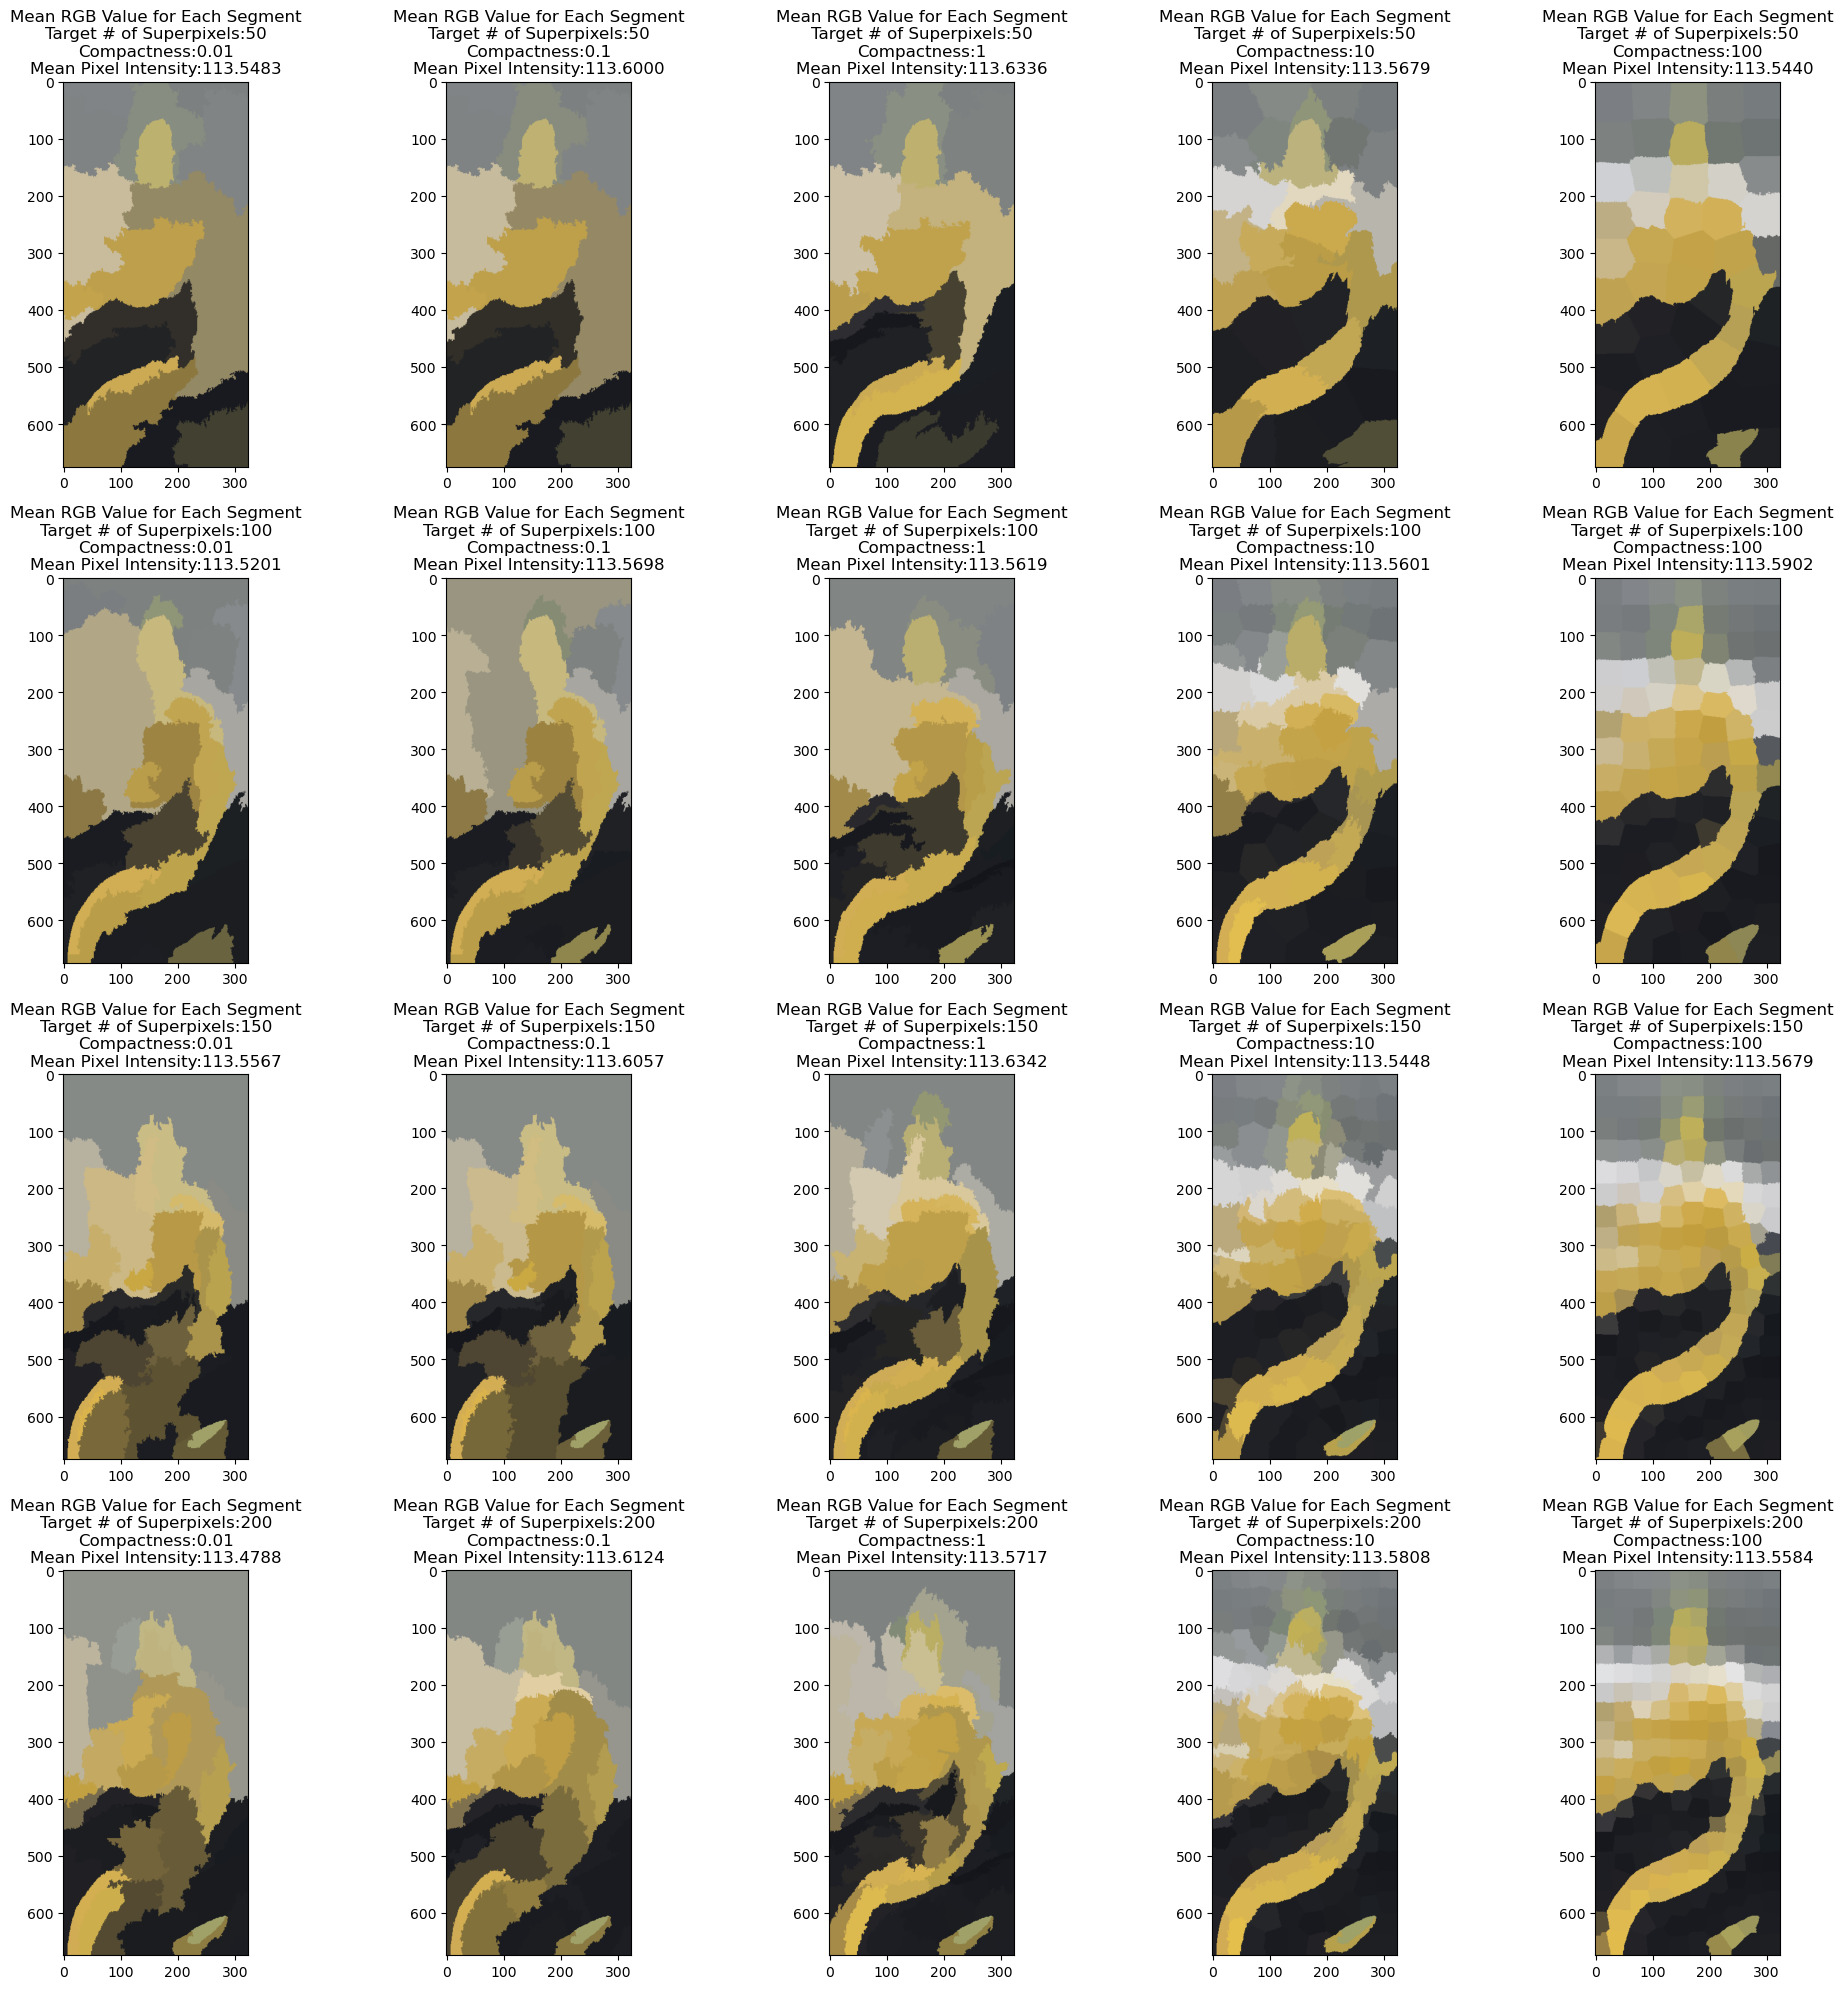

In [19]:
# Display the results of the SLIC algorithm as 
# instructed above for each parameter setting 

# make subplot to display each result
fig, ax = plt.subplots(np.size(num_segments), np.size(comp), figsize=(20,20))

# cycle through each condition
for i in range(0, np.size(num_segments)):
    for j in range(0, np.size(comp)):

        # get results for this trial
        slic_results = slic_results_array[i,j,:,:]

        # replace original RGB values in segment with mean RGB values in segment
        meanRGBSegmentedImg = np.zeros(icelandImg.shape).astype('int') # initialize image to store result

        for segment in range(0, np.max(slic_results)): # cycle through each segment
            pixelsInSigment = np.sum(np.where(slic_results == (segment+1), 1, 0)) # find number of pixels in this segment

            for c in range(0,3): # repeat for each color
                sumColorValue = np.sum(np.where(slic_results == (segment+1), icelandImg[:,:,c], 0)) # sum up all color values for this color in this segment
                averageColorValue = int(sumColorValue / pixelsInSigment) # divide by number of pixels to get the average. 

                meanRGBSegmentedImg[:,:,c] = np.where(slic_results == (segment+1), averageColorValue, meanRGBSegmentedImg[:,:,c])

        ax[i,j].imshow(meanRGBSegmentedImg)
        ax[i,j].set_title(f"Mean RGB Value for Each Segment\nTarget # of Superpixels:{num_segments[i]}\nCompactness:{comp[j]}\nMean Pixel Intensity:{np.mean(meanRGBSegmentedImg):0.4f}")
        ax[i,j].axis("image")

plt.tight_layout()
plt.show()


### Discussion
As the compactness increases, the superpixels have more regular, block-like shapes. At lower compactness, the edges of the superpixels are very fluid and wrap to the image features better. The target number of superpixels obviously increases the number of blobs, but at low compactness levels, sometimes there is not a noticeable change in the number of superpixels or no noticeable difference between superpixels. 

I thought it was interesting how only the high compactness trials produced any of the white wash on the shore. I thought this was a pretty distinct feature in the images. 

The mean pixel intensity is very similar for each trail (always around 113.5).

# Part 4) K-means Clustering Segmentation: [6 pts]

### For the same 'iceland.png' image, apply k-means clustering based segmentation using the OpenCV's k-means clustering (Use the helper code given below for k-means setup. Make sure you set the given random seed below everytime before running k-means for getting deterministic results for evaluation.)

### i. Cluster the pixels using the 3D vector of [R, G, B] features with k = 10. Replace the cluster labels with the corresponding cluster's center values and reshape it back to the original image shape. 

### ii. Next cluster the pixels using the 5D vector of [R, G, B] features. Experiment with k = 10, 50, 100. For each k-means result, replace the cluster labels with the corresponding cluster's center values and reshape it back to the original image shape. 

### iv. Display all the above resulting segmented images side by side using plt.subplots(). Compare and discuss the results. 

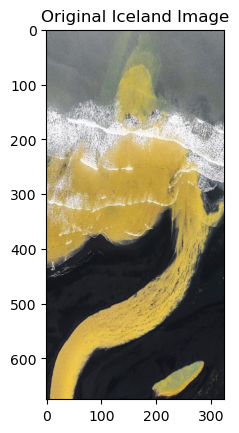

In [20]:
# Read and display the input image

icelandImg = skimage.io.imread("iceland.png") # read

plt.imshow(icelandImg)
plt.axis("image")
plt.title("Original Iceland Image")
plt.show()
# same code as above

In [21]:
# K-means using 3D vector of [R, G, B] features with k = 10.

# K-means Setup (Use this block before every K-means run)
cv2.setRNGSeed(0) # Sets random seed 
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,\
            100, 0.85) # K-means stopping criteria 
k = 10 # Edit the k-value as needed for the experiment 

# Enter your code to generate the input features for K-means
# want num_pixels * 3 array to store input features
input_features = np.zeros([icelandImg.shape[0]* icelandImg.shape[1], 3], dtype='float32')

for row in range(0,icelandImg.shape[0]): # cycle through each pixel
    for col in range(0, icelandImg.shape[1]):

        # want input features to be a num_pixels * num_features array with [R, G, B] for each point 
        index = row*icelandImg.shape[1] + col
        input_features[index,:] = icelandImg[row,col]

# print(input_features.dtype) # debugging

# K-means using OpenCV (Use this same setup for every run. 
# Only change the input_features and k values)
retval, labels, centers = cv2.kmeans(input_features, k,\
                                     None, criteria, 10,\
                                     cv2.KMEANS_PP_CENTERS)

# print(retval, np.min(labels), np.max(labels), centers.shape) # testing

# create array to store segmented image
kMeansImg_3d_k10 = np.zeros(icelandImg.shape, dtype='int')

# for each pixel, update appropriately in kMeansImg
for row in range(0, kMeansImg_3d_k10.shape[0]):
    for col in range(0, kMeansImg_3d_k10.shape[1]):

        index = row*kMeansImg_3d_k10.shape[1] + col
        thisLabel = labels[index]

        kMeansImg_3d_k10[row,col,:] = centers[thisLabel]


In [22]:
# K-means using 5D vector of [X, Y, R, G, B] features. 
# Experiment with k = 10

# K-means Setup (Use this block before every K-means run)
cv2.setRNGSeed(0) # Sets random seed 
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,\
            100, 0.85) # K-means stopping criteria 
k = 10 # Edit the k-value as needed for the experiment 

# Enter your code to generate the input features for K-means
# want num_pixels * 3 array to store input features
input_features = np.zeros([icelandImg.shape[0]* icelandImg.shape[1], 5], dtype='float32')

for row in range(0,icelandImg.shape[0]): # cycle through each pixel
    for col in range(0, icelandImg.shape[1]):

        # want input features to be a num_pixels * num_features array with [R, G, B] for each point 
        index = row*icelandImg.shape[1] + col
        input_features[index,:] = [col, row, icelandImg[row,col,0], icelandImg[row,col,1], icelandImg[row,col,2]]

# print(input_features.dtype) # debugging

# K-means using OpenCV (Use this same setup for every run. 
# Only change the input_features and k values)
retval, labels, centers = cv2.kmeans(input_features, k,\
                                     None, criteria, 10,\
                                     cv2.KMEANS_PP_CENTERS)

# print(retval, np.min(labels), np.max(labels), labels.shape, centers.shape) # testing

# create array to store segmented image
kMeansImg_5d_k10 = np.zeros(icelandImg.shape, dtype='int')

# for each pixel, update appropriately in kMeansImg
for input_feature in range(0, input_features.shape[0]):

    thisLabel = labels[input_feature] # get label for the pixel
    rowNum = int(input_features[input_feature, 1]) # get row and column from unpacking from the input features vector
    colNum = int(input_features[input_feature, 0])

    kMeansImg_5d_k10[rowNum,colNum,:] = centers[thisLabel, 2:] # assign value for pixel to new segmented image


In [23]:
# K-means using 5D vector of [X, Y, R, G, B] features. 
# Experiment with k = 50

# K-means Setup (Use this block before every K-means run)
cv2.setRNGSeed(0) # Sets random seed 
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,\
            100, 0.85) # K-means stopping criteria 
k = 50 # Edit the k-value as needed for the experiment 

# Enter your code to generate the input features for K-means
# want num_pixels * 3 array to store input features
input_features = np.zeros([icelandImg.shape[0]* icelandImg.shape[1], 5], dtype='float32')

for row in range(0,icelandImg.shape[0]): # cycle through each pixel
    for col in range(0, icelandImg.shape[1]):

        # want input features to be a num_pixels * num_features array with [R, G, B] for each point 
        index = row*icelandImg.shape[1] + col
        input_features[index,:] = [col, row, icelandImg[row,col,0], icelandImg[row,col,1], icelandImg[row,col,2]]

# print(input_features.dtype) # debugging

# K-means using OpenCV (Use this same setup for every run. 
# Only change the input_features and k values)
retval, labels, centers = cv2.kmeans(input_features, k,\
                                     None, criteria, 10,\
                                     cv2.KMEANS_PP_CENTERS)

# print(retval, np.min(labels), np.max(labels), labels.shape, centers.shape) # testing

# create array to store segmented image
kMeansImg_5d_k50 = np.zeros(icelandImg.shape, dtype='int')

# for each pixel, update appropriately in kMeansImg
for input_feature in range(0, input_features.shape[0]):

    thisLabel = labels[input_feature] # get label for the pixel
    rowNum = int(input_features[input_feature, 1]) # get row and column from unpacking from the input features vector
    colNum = int(input_features[input_feature, 0])

    kMeansImg_5d_k50[rowNum,colNum,:] = centers[thisLabel, 2:] # assign value for pixel to new segmented image


In [24]:
# K-means using 5D vector of [X, Y, R, G, B] features. 
# Experiment with k = 100

# K-means Setup (Use this block before every K-means run)
cv2.setRNGSeed(0) # Sets random seed 
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,\
            100, 0.85) # K-means stopping criteria 
k = 100 # Edit the k-value as needed for the experiment 

# Enter your code to generate the input features for K-means
# want num_pixels * 3 array to store input features
input_features = np.zeros([icelandImg.shape[0]* icelandImg.shape[1], 5], dtype='float32')

for row in range(0,icelandImg.shape[0]): # cycle through each pixel
    for col in range(0, icelandImg.shape[1]):

        # want input features to be a num_pixels * num_features array with [R, G, B] for each point 
        index = row*icelandImg.shape[1] + col
        input_features[index,:] = [col, row, icelandImg[row,col,0], icelandImg[row,col,1], icelandImg[row,col,2]]

# print(input_features.dtype) # debugging

# K-means using OpenCV (Use this same setup for every run. 
# Only change the input_features and k values)
retval, labels, centers = cv2.kmeans(input_features, k,\
                                     None, criteria, 10,\
                                     cv2.KMEANS_PP_CENTERS)

# print(retval, np.min(labels), np.max(labels), labels.shape, centers.shape) # testing

# create array to store segmented image
kMeansImg_5d_k100 = np.zeros(icelandImg.shape, dtype='int')

# for each pixel, update appropriately in kMeansImg
for input_feature in range(0, input_features.shape[0]):

    thisLabel = labels[input_feature] # get label for the pixel
    rowNum = int(input_features[input_feature, 1]) # get row and column from unpacking from the input features vector
    colNum = int(input_features[input_feature, 0])

    kMeansImg_5d_k100[rowNum,colNum,:] = centers[thisLabel, 2:] # assign value for pixel to new segmented image


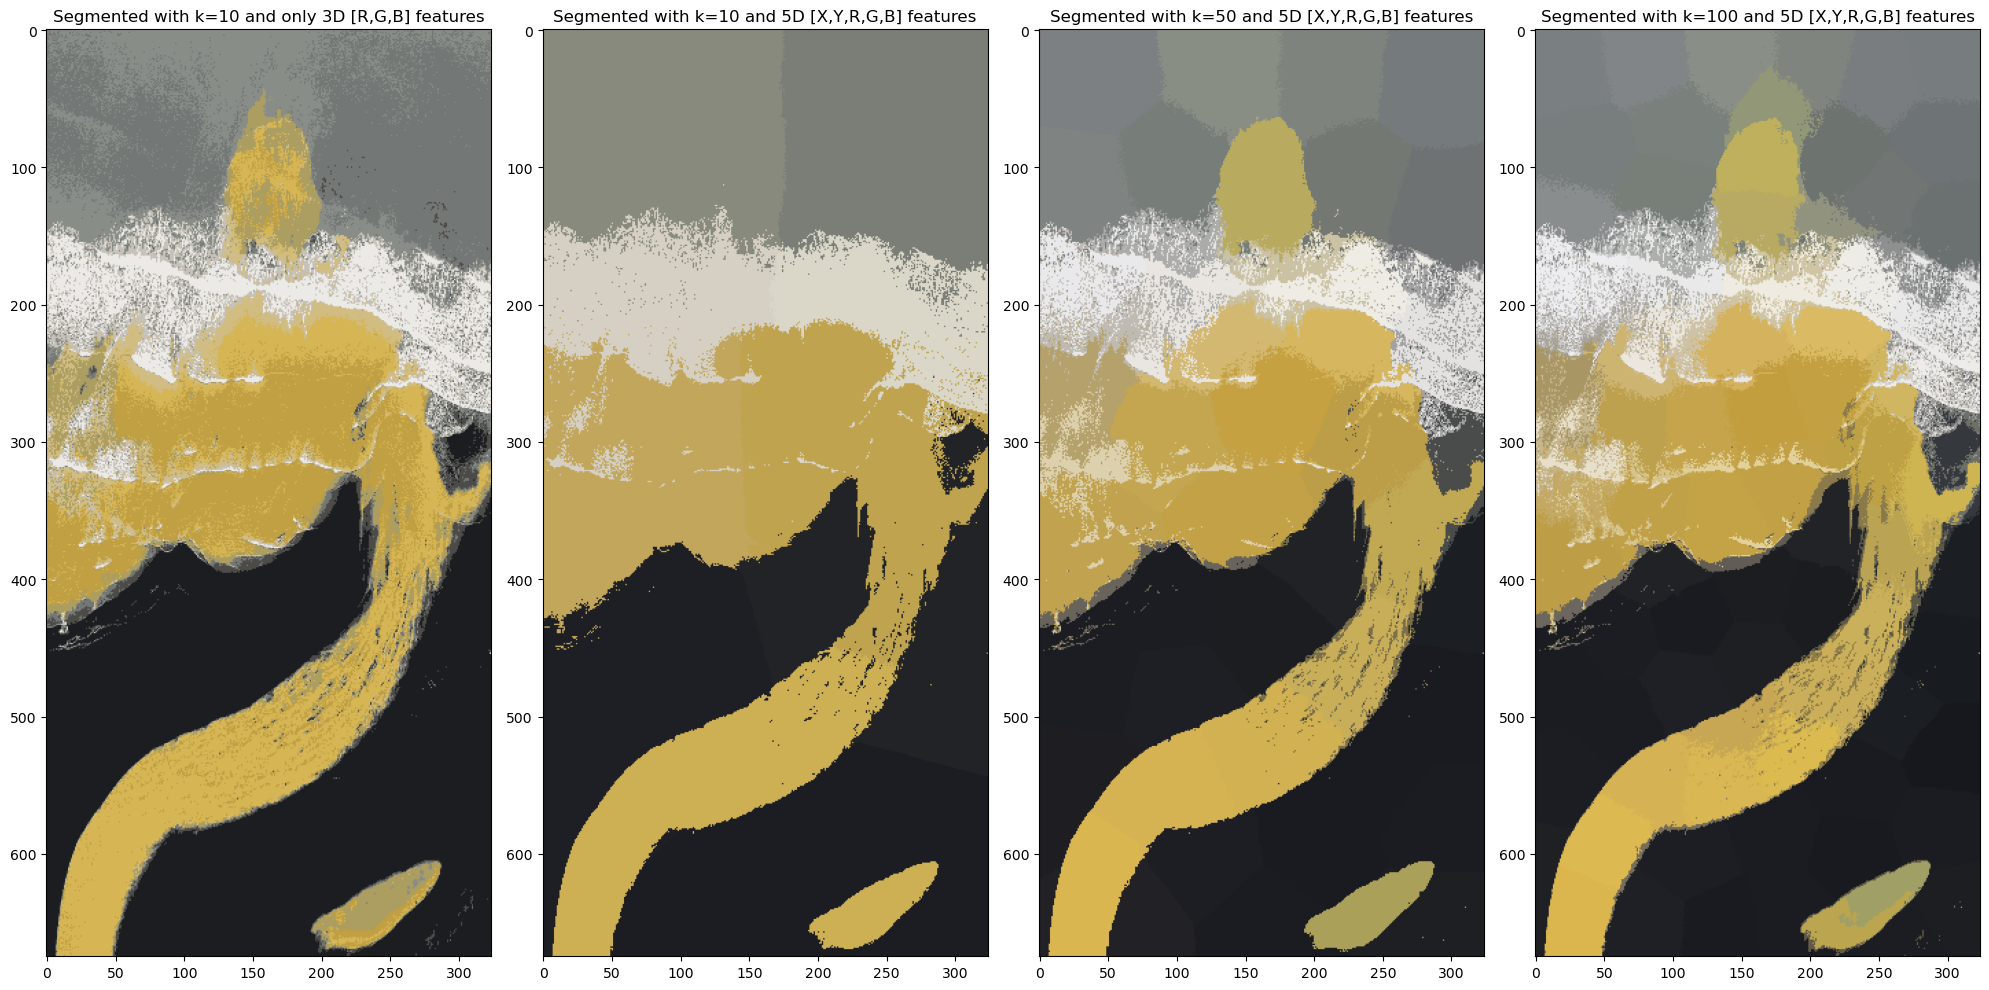

In [27]:
# Subplots for displaying the k-means results side-by-side

fig, ax = plt.subplots(1,4, figsize=(20,20))

ax[0].imshow(kMeansImg_3d_k10) # display 1st image (3d, k=10)
ax[0].set_title("Segmented with k=10 and only 3D [R,G,B] features")
ax[0].axis('image')

ax[1].imshow(kMeansImg_5d_k10) # display 2nd image (5d, k=10)
ax[1].set_title("Segmented with k=10 and 5D [X,Y,R,G,B] features")
ax[1].axis('image')

ax[2].imshow(kMeansImg_5d_k50) # display 3rd image (5d, k=50)
ax[2].set_title("Segmented with k=50 and 5D [X,Y,R,G,B] features")
ax[2].axis('image')

ax[3].imshow(kMeansImg_5d_k100) # display 4th image (5d, k=100)
ax[3].set_title("Segmented with k=100 and 5D [X,Y,R,G,B] features")
ax[3].axis('image')


plt.tight_layout() # show plot
plt.show()


### Discussion
I think this segmenting is very satisfying - I really like the style of images they produce. 

The [R,G,B] only segment is hard to discern from the original image, without it being present, since there are no spatial boundaries on the segments. The area where you can tell something is up is the sea, where there are spotty regions where the pixels split between two colors. 

For the 5D feature images, these do a better job of spatially seperating and highlighting features, but more clusters are needed to get an image that resembles the original as well as the 3D image does to the human eye. The 50 and 100 segment images do a good job of capturing the noiser features, but all three 5D images have multiple segments for the relatively uniform color top and bottom regions, which I thought was interesting. The k=10, 5D feature segment would be better than the images with more segments at identifying the different semantic segments of the image (like the ocean vs the white wash vs the yellow area vs the black land), since this feature does not have 50-100 unique segments. However, it does a worse job at physical recreating the original image to the human eye (which probably isnt the point when using this algorithm). 

## Final Submission 
1. Ensure you save the Notebook after adding all your code and discussion of results.
2. Verify that your completed Submission Notebook file follows the file naming convention lastname_OSUdotNumber_HW7.ipynb (for example: davis_1719_HW7.ipynb)
2. Make a lastname_OSUdotNumber_HW7.zip (for example: davis_1719_HW7.zip) file containing your submission notebook file along with the input data required for the homework.
3. Upload your zip file to Carmen (Only zip file submissions will be accepted on Carmen).

Make sure to upload your submission BEFORE the deadline and verify that it was indeed accepted by Carmen!